In [1]:
import matplotlib.pyplot as plt
import control as co
import pandas as pd
import numpy as np 
import sympy as sp
import time 

from sympy.abc import a, b, q, s, z, omega, zeta
from numpy.linalg import inv

In [2]:
u, uc, vs, y, ys, Gs, Gz, Hq = sp.symbols('u(k),u_c{(k)},v(s),y(k),y(s),G(s),G(z),H(q)')
Ts = sp.symbols('T_s')

am1, am2, bm0, bm1 = sp.symbols('a_{m_1},a_{m_2},b_{m_0},b_{m_1}')
ao, a1, a2, b0, b1 = sp.symbols('a_o,a_1,a_2,b_0,b_1')
r0, s0, s1, t0, t1 = sp.symbols('r_0,s_0,s_1,t_0,t_1')

Ts_val = 0.2 # We can modify the sampling time but it can't get much lower than 0.2s with the maths

Gs_eq = sp.Eq(Gs, b/(s*(s + b)))

The model is given by {{Gs_eq}}. To discretize, 

$ G(z) =  (1-z^{-1})\mathscr{Z}\big\{\frac{b}{s^2(s+b)}\big\} $

$ G(z) =  (1-z^{-1})\mathscr{Z}\big\{\frac{1}{s^2} - \frac{1}{bs} + \frac{1}{b(b + s)} \big\} $

$ G(z) =  (1-z^{-1})\big(\frac{T_sz}{(z-1)^2} - \frac{1}{b} \frac{z}{z-1} + \frac{1}{b} \frac{z}{z-e^{-bT_s}}\big) $

In [3]:
Gz_eq_Ts_b = sp.simplify(sp.expand((1-1/z)*(Ts*z/(z-1)**2 - z/(b*(z-1)) + z/(b*(z-sp.exp(-b*Ts))))))

num, den = sp.fraction(Gz_eq_Ts_b)
den_poly = sp.Poly(den, z)
mono_div = den_poly.coeffs()[0]
# sub_validation = [(Ts, 0.5), (b, 1)]

In [4]:
sp.collect(sp.simplify(Gz_eq_Ts_b), z)

(-T_s*b + z*(T_s*b*exp(T_s*b) - exp(T_s*b) + 1) + exp(T_s*b) - 1)/(b*(z**2*exp(T_s*b) + z*(-exp(T_s*b) - 1) + 1))

## Pulse Function

In [5]:
## Example 3.1: since it has the same structure TF I used it to validate my approach, it's consistent
# Ts_val = 0.5
# sub_vals = [(Ts, Ts_val), (b, b_nom)]

## This is for our project
# sub_vals = [(Ts, Ts_val), (b, 6.58436748684758)] # b here was found based on measured values
sub_vals = [(Ts, Ts_val)]

num_mono_z = sp.collect(num/mono_div, z).subs(sub_vals) # Probably in the loop it's easier to use Poly and .coeffs()
den_mono_z = sp.collect(den/mono_div, z).subs(sub_vals) # Probably in the loop it's easier to use Poly and .coeffs()

In [6]:
num_sym, denum_sym = sp.symbols('num,denum')
display(sp.Eq(num_sym, num_mono_z)) 
display(sp.Eq(denum_sym, den_mono_z))

Eq(num, (-0.2*b + z*(0.2*b*exp(0.2*b) - exp(0.2*b) + 1) + exp(0.2*b) - 1)*exp(-0.2*b)/b)

Eq(denum, (z**2*exp(0.2*b) + z*(-exp(0.2*b) - 1) + 1)*exp(-0.2*b))

In [7]:
Hq = num_mono_z/den_mono_z
Hq.subs(sub_vals)

(-0.2*b + z*(0.2*b*exp(0.2*b) - exp(0.2*b) + 1) + exp(0.2*b) - 1)/(b*(z**2*exp(0.2*b) + z*(-exp(0.2*b) - 1) + 1))

## Stability Check

This is a sanity check with the nominal values to check the stability of the zeros. Here, the zero is unstable for a nominal value of $ b = 6.58436748684758 $. 

In [8]:
radius = 38/2000  # 38 mm diameter to radius in m
mass = 4/7000  # grams per ball
area_ball = np.pi * radius**2
volume_ball = 4/3*np.pi*radius**3
density = 1.2  # kg/m^3
veq = 2.8 # m/s

b_nom = 2*9.81*(mass-density*volume_ball)/(mass*veq)

### Nominal Pulse Function

In [9]:
sub_vals = [(Ts, Ts_val), (b, b_nom)]
pulse_nom = num_mono_z.subs(sub_vals)/den_mono_z.subs(sub_vals)
pulse_nom

(0.0888233086497573*z + 0.0575823297146081)/(1.0*z**2 - 1.26797180817817*z + 0.267971808178173)

In [10]:
num_mono_poly = sp.Poly(num_mono_z.subs(b, b_nom), z)
num_coeffs = num_mono_poly.coeffs()
nom_zero = (num_coeffs[0]/num_coeffs[1]).subs(b, b_nom) # Value of the zero

In [11]:
new_coeffs = []
for i in den_poly.coeffs():
    new_coeffs.append((i/den_poly.coeffs()[0]).subs(sub_vals))
# np.roots(new_coeffs) # Marginally stable

In [12]:
num_pulse_nom = num_mono_poly.coeffs()
den_pulse_nom = new_coeffs
display(num_pulse_nom)
display(den_pulse_nom)
pulse_coeffs = den_pulse_nom[1:]
for n in num_pulse_nom:
    pulse_coeffs.append(n)

[0.0888233086497573, 0.0575823297146081]

[1, -1.26797180817817, 0.267971808178173]

## Control Parameter Derivation

Given that the zeros are unstable, the parameters are derived without zero cancelation.  

Here we know from the compatability conditions that, 

$ \text{degA}_m = \text{degA} = 2 $

$ \text{degB}_m = \text{degB} = 1 $

Since the zeros in $ B $ are unstable then $ B^+ = 1 $ and $ B^- = B = b_0q + b_1 $

Then, 

$ \text{degA}_o = \text{degA} - \text{degB}^+ - 1 = 2 - 0 - 1 = 1 $

Using the Diophantine equation we get, 

$ AR + BS = A_oA_m $

Let $ A_o = q + a_0$

Since the process is second order, then, 

$ \text{degR} = \text{degS} = \text{degT} = 1 $, 

with R being monic. 

### Process values

In [13]:
A = den_mono_z.subs(z, q)
B = num_mono_z.subs(z, q)
_A = q**2 + a1*q + a2
_B = b0*q + b1
process = _B/_A
# display(process)

### Model values

In [14]:
wn = 1
damp = 0.7
poles = co.sample_system(co.tf([1], [1, 2*0.7, 1]), Ts=0.5, method='zoh').pole()
co_mo = sp.Poly(sp.expand((q + poles[0])*(q + poles[1]))).coeffs()
Am = co_mo[0]*q**2 + co_mo[1]*q + co_mo[2]
Bm = (Am/B).subs(q, 1)*B
_Am = q**2 + am1*q + am2
_beta = (_Am/_B).subs(q, 1)
_Bm = sp.simplify(sp.expand(_beta*_B))
_Ao = q + ao
# _Ao = q
# Bm.subs(b, b_nom)

### Control Parameters

In [15]:
_R = q + r0
_S = s0*q + s1
_T = t0*q + t1

Diophantine equation: 

In [16]:
# diophantine = sp.Eq(sp.collect(sp.simplify(sp.expand(_A*_R + _B*_S)), q), 
#                     sp.collect(sp.expand(_Ao*_Am), q))
diophantine = sp.Eq((_A*_R + _B*_S), (_Ao*_Am))
dio_LHS_coeffs = sp.Poly((_A*_R + _B*_S), q).coeffs()
dio_RHS_coeffs = sp.Poly(_Ao*_Am, q).coeffs()

In [17]:
diophantine

Eq((q + r_0)*(a_1*q + a_2 + q**2) + (b_0*q + b_1)*(q*s_0 + s_1), (a_o + q)*(a_{m_1}*q + a_{m_2} + q**2))

In [18]:
# for i in range(len(dio_LHS_coeffs)):
#     print(f'i = {s**(3 - i)}\nLHS = ')
#     display(dio_LHS_coeffs[i])
#     print('RHS = ')
#     display(dio_RHS_coeffs[i])
#     print('\n\n')

#### Finding $r_0$

In [19]:
_s0 = sp.solve(dio_LHS_coeffs[1] - dio_RHS_coeffs[1], s0)[0] 
_s1 = sp.solve((dio_LHS_coeffs[2] - dio_RHS_coeffs[2]).subs(s0, _s0), s1)[0]
_r0 = sp.solve((dio_LHS_coeffs[3] - dio_RHS_coeffs[3]).subs(s1, _s1), r0)[0]
_r0

(-a_1*b_1**2 + a_2*b_0*b_1 - a_o*a_{m_1}*b_0*b_1 + a_o*a_{m_2}*b_0**2 + a_o*b_1**2 + a_{m_1}*b_1**2 - a_{m_2}*b_0*b_1)/(-a_1*b_0*b_1 + a_2*b_0**2 + b_1**2)

#### Finding $s_0$

In [20]:
_s0 = sp.solve((dio_LHS_coeffs[1] - dio_RHS_coeffs[1]).subs(r0, _r0), s0)[0] 
_s0

(a_1**2*b_1 - a_1*a_2*b_0 - a_1*a_o*b_1 - a_1*a_{m_1}*b_1 + a_2*a_o*b_0 + a_2*a_{m_1}*b_0 - a_2*b_1 + a_o*a_{m_1}*b_1 - a_o*a_{m_2}*b_0 + a_{m_2}*b_1)/(-a_1*b_0*b_1 + a_2*b_0**2 + b_1**2)

#### Finding $s_1$

In [21]:
_s1 = sp.solve((dio_LHS_coeffs[2] - dio_RHS_coeffs[2]).subs([(s0, _s0), (r0, _r0)]), s1)[0]
_s1

(a_1*a_2*b_1 - a_1*a_o*a_{m_2}*b_0 - a_2**2*b_0 + a_2*a_o*a_{m_1}*b_0 - a_2*a_o*b_1 - a_2*a_{m_1}*b_1 + a_2*a_{m_2}*b_0 + a_o*a_{m_2}*b_1)/(-a_1*b_0*b_1 + a_2*b_0**2 + b_1**2)

#### Finding T

In [22]:
T = sp.collect(sp.simplify(sp.expand(_Bm/_B*_Ao)), q)
num_T, den_T = sp.fraction(T)
num_T_coeffs = sp.Poly(num_T, q).coeffs()
_t0 = num_T_coeffs[0]/den_T
_t1 = num_T_coeffs[1]/den_T

In [23]:
_t0

(a_{m_1} + a_{m_2} + 1)/(b_0 + b_1)

In [24]:
_t1

(a_o*a_{m_1} + a_o*a_{m_2} + a_o)/(b_0 + b_1)

In [25]:
T

(a_o*a_{m_1} + a_o*a_{m_2} + a_o + q*(a_{m_1} + a_{m_2} + 1))/(b_0 + b_1)

### Control Action

In [26]:
uk1,  uck1, yk1 = sp.symbols('u(k-1),u_c{(k-1)},y(k-1)')
control_action = (sp.expand(sp.Eq((_R*u)/q, (_T*uc - _S*y)/q)))
control_action
control_subs = [(1/q*u, uk1), (1/q*uc, uck1), (1/q*y, yk1)]
control_action_sol = sp.Eq(u, sp.solve(control_action.subs(control_subs), u)[0])
control_action_sol

Eq(u(k), -r_0*u(k-1) - s_0*y(k) - s_1*y(k-1) + t_0*u_c{(k)} + t_1*u_c{(k-1)})

In [27]:
# control_action_sol.rhs.subs([(a1, )])

In [28]:
pulse_coeffs

[-1.26797180817817, 0.267971808178173, 0.0888233086497573, 0.0575823297146081]

In [29]:
_T

q*t_0 + t_1

In [30]:
_R

q + r_0

In [31]:
TR = sp.symbols('T//R')
TR_ = (sp.simplify(sp.expand(_T.subs([(t0, _t0), (t1, _t1)])/_R.subs(r0, _r0))))

num,den = sp.fraction(TR_)
sp.collect(sp.expand(den), q)


-a_1*b_0*b_1**2 - a_1*b_1**3 + a_2*b_0**2*b_1 + a_2*b_0*b_1**2 - a_o*a_{m_1}*b_0**2*b_1 - a_o*a_{m_1}*b_0*b_1**2 + a_o*a_{m_2}*b_0**3 + a_o*a_{m_2}*b_0**2*b_1 + a_o*b_0*b_1**2 + a_o*b_1**3 + a_{m_1}*b_0*b_1**2 + a_{m_1}*b_1**3 - a_{m_2}*b_0**2*b_1 - a_{m_2}*b_0*b_1**2 + q*(-a_1*b_0**2*b_1 - a_1*b_0*b_1**2 + a_2*b_0**3 + a_2*b_0**2*b_1 + b_0*b_1**2 + b_1**3)

In [32]:
sp.collect(sp.simplify(sp.expand(_T.subs([(t0, _t0), (t1, _t1)])/_R.subs(r0, _r0))), q)

(-a_1*b_0*b_1 + a_2*b_0**2 + b_1**2)*(a_o*a_{m_1} + a_o*a_{m_2} + a_o + q*(a_{m_1} + a_{m_2} + 1))/(-a_1*b_0*b_1**2 - a_1*b_1**3 + a_2*b_0**2*b_1 + a_2*b_0*b_1**2 - a_o*a_{m_1}*b_0**2*b_1 - a_o*a_{m_1}*b_0*b_1**2 + a_o*a_{m_2}*b_0**3 + a_o*a_{m_2}*b_0**2*b_1 + a_o*b_0*b_1**2 + a_o*b_1**3 + a_{m_1}*b_0*b_1**2 + a_{m_1}*b_1**3 - a_{m_2}*b_0**2*b_1 - a_{m_2}*b_0*b_1**2 + q*(b_0 + b_1)*(-a_1*b_0*b_1 + a_2*b_0**2 + b_1**2))

## Simulation

### Process Deivation

$ y(k) = -a_1y(k-1) - a_2y(k-2) + b_0u(k-1) + b_1u(k-2) = \phi(t-1)^T\theta $

where, 

$ \phi(t-1) = \big[-y(k-1)\ -y(k-2)\ u(k-1)\ u(k-2)\big]^T $

and 

$ \theta = \big[a_1\ a_2\ b_0\ b_1\big]^T $

### Model Derivation
$ y_m(k) = -a_{m_1}y_m(k-1) - a_{m_2}y(k-2) + b_{m_0}u_c(k-1) + b_{m_1}u_c(k-2) = \phi_m(t-1)^T\vartheta$

where the parameters are defined as shown below,

In [33]:
omega_n = np.sqrt(2)/8
zeta = 1
Bmz_tf, Amz_tf = co.tfdata(co.sample_system(co.tf([1], [1, 2*zeta*omega_n, omega_n**2]), method='zoh', Ts=Ts_val))
AM1 = Amz_tf[0][0][1]
AM2 = Amz_tf[0][0][2]
A0 = 0.01
T0_num = AM1 + AM2 + 1
T1_num = A0*(T0_num)
lam = 1
initial_P_weights = [1000]*4
# initial_P_weights = [1000, 100, 10, 10]
theta = np.array(pulse_coeffs, float).reshape(4, -1)

print(AM1)
print(AM2)
display(pulse_coeffs)
pulse_coeffs[0]

-1.9305247197830901
0.9317314234233947


[-1.26797180817817, 0.267971808178173, 0.0888233086497573, 0.0575823297146081]

-1.26797180817817

In [34]:
test = control_action_sol.subs([(r0, _r0), (s0, _s0), (s1, _s1), (t0, _t0), (t1, _t1), (ao, A0), (a1, pulse_coeffs[0]), (a2, pulse_coeffs[1]), (b0, pulse_coeffs[2]), (b1, pulse_coeffs[3])])
test.subs([(am1, AM1), (am2, AM2)])
# display(pulse_coeffs[3])
# display(AM2)

Eq(u(k), 0.452057974901955*u(k-1) + 0.00824219376921357*u_c{(k)} + 8.24219376921338e-5*u_c{(k-1)} + 2.25723337433354*y(k) - 2.26555799004045*y(k-1))

In [35]:
control_action_sol

Eq(u(k), -r_0*u(k-1) - s_0*y(k) - s_1*y(k-1) + t_0*u_c{(k)} + t_1*u_c{(k-1)})

In [37]:
final_time = 10000
t = np.arange(0, final_time + Ts_val, Ts_val)
def reference_signal(end_time=final_time, Ts_func=Ts_val, lower_set=0., upper_set=0.25, period=400):
    uc_func = []
    time = np.arange(0, end_time + Ts_func, Ts_func)
    for _t in time:
        rat = 2*np.pi/period
        if np.sin(rat*_t) >= 0:
            uc_func.append(upper_set)
        else:
            uc_func.append(lower_set)
    return np.array(uc_func, float)
uc_val = reference_signal()
# plt.plot(np.arange(0, 60 + Ts_val, Ts_val), uc)
# plt.show()

In [38]:
    # Estimates k = 0
# theta_hat = np.array(pulse_coeffs, float).reshape(4, -1) # a1, a2, b0, b1 THIS WILL BE USED FOR THE REAL CONTROL 
theta_hat = np.array([-1.1, 0.25, 0.1, 0.05], float).reshape(4, -1)
# theta_hat = np.array([0.0, 0.0, 0.5, 0.5], float).reshape(4, -1)
theta_arr = theta_hat
P = np.diag(initial_P_weights)
phi = np.zeros((4,1))

    # Measurements and control parameters k = 0
y_measure = (phi.T@theta).reshape(-1,) 

a1, a2, b0, b1 = theta_hat[0], theta_hat[1], theta_hat[2], theta_hat[3]
den_rs = ((-a1*b0*b1) + (a2*b0**2) + b1**2)   
den_t = b0 + b1
r0_val = 1/den_rs*((A0*AM2)*b0**2 + (-a1 + A0 + AM1)*b1**2 + (a2 - A0*AM1 - AM2)*b0*b1)
s0_val = 1/den_rs*((-a1*a2 + a2*(A0 + AM1) - A0*AM2)*b0 + (a1**2 - a1*(A0 + AM1) - a2 + A0*AM1 + AM2)*b1)
s1_val = 1/den_rs*((-a2**2 + A0*(a2*AM1 - a1*AM2) + a2*AM2)*b0 + (a2*(a1 - A0 - AM1) + A0*AM2)*b1)
t0_val = T0_num/den_t
t1_val = T1_num/den_t

M = np.array([r0_val, s0_val, s1_val, t0_val, t1_val], float).reshape(-1, 1)
N = np.array([0, -y_measure[0], 0, uc_val[0], 0], float).reshape(M.shape)
u_val = (N.T@M).reshape(-1,)

    # Estimates k = 1
phi = np.array([-y_measure[0], 0, u_val[0], 0], float).reshape(-1,1) # phi of 0
K = P@phi@inv(lam + phi.T@P@phi)
theta_hat = theta_hat + K@(phi.T@theta - phi.T@theta_hat)
theta_arr = np.concatenate((theta_arr, 
                            theta_hat.reshape(-1, 1)), axis=1)
P = (np.eye(len(phi)) - K@phi.T) @P/lam

    # Measurements and control parameters k = 1
y_measure = np.concatenate((y_measure,
                            (phi.T@theta).reshape(-1,)))   

a1, a2, b0, b1 = theta_hat[0], theta_hat[1], theta_hat[2], theta_hat[3]
den_rs = ((-a1*b0*b1) + (a2*b0**2) + b1**2)   
den_t = b0 + b1
r0_val = 1/den_rs*((A0*AM2)*b0**2 + (-a1 + A0 + AM1)*b1**2 + (a2 - A0*AM1 - AM2)*b0*b1)
s0_val = 1/den_rs*((-a1*a2 + a2*(A0 + AM1) - A0*AM2)*b0 + (a1**2 - a1*(A0 + AM1) - a2 + A0*AM1 + AM2)*b1)
s1_val = 1/den_rs*((-a2**2 + A0*(a2*AM1 - a1*AM2) + a2*AM2)*b0 + (a2*(a1 - A0 - AM1) + A0*AM2)*b1)
t0_val = T0_num/den_t
t1_val = T1_num/den_t

M = np.array([r0_val, s0_val, s1_val, t0_val, t1_val], float).reshape(-1, 1)
N = np.array([-u_val[0], -y_measure[1], -y_measure[0], uc_val[1], uc_val[0]],float).reshape(M.shape)
u_val = np.concatenate((u_val, 
                        (N.T@M).reshape(-1,)))

for k in range(2, len(t)):
        phi = np.array([-y_measure[k-1], -y_measure[k-2], u_val[k-1], u_val[k-2]], float).reshape(-1,1)
        K = P@phi@inv(lam + phi.T@P@phi)
        theta_hat = theta_hat + K@(phi.T@theta - phi.T@theta_hat)
        theta_arr = np.concatenate((theta_arr, 
                                    theta_hat.reshape(-1, 1)), axis=1)
        P = (np.eye(len(phi)) - K@phi.T)@P/lam

            # Measurements and control parameters k = 2
        y_measure = np.concatenate((y_measure,
                                    (phi.T@theta).reshape(-1,)))  

        a1, a2, b0, b1 = theta_hat[0], theta_hat[1], theta_hat[2], theta_hat[3]
        den_rs = ((-a1*b0*b1) + (a2*b0**2) + b1**2)   
        den_t = b0 + b1
        r0_val = 1/den_rs*((A0*AM2)*b0**2 + (-a1 + A0 + AM1)*b1**2 + (a2 - A0*AM1 - AM2)*b0*b1)
        s0_val = 1/den_rs*((-a1*a2 + a2*(A0 + AM1) - A0*AM2)*b0 + (a1**2 - a1*(A0 + AM1) - a2 + A0*AM1 + AM2)*b1)
        s1_val = 1/den_rs*((-a2**2 + A0*(a2*AM1 - a1*AM2) + a2*AM2)*b0 + (a2*(a1 - A0 - AM1) + A0*AM2)*b1)
        t0_val = T0_num/den_t
        t1_val = T1_num/den_t

        M = np.array([r0_val, s0_val, s1_val, t0_val, t1_val], float).reshape(-1, 1)
        N = np.array([-u_val[k-1], -y_measure[k], -y_measure[k-1], uc_val[k], uc_val[k-1]]).reshape(M.shape)
        u_val = np.concatenate((u_val, 
                                (N.T@M).reshape(-1,)))

In [39]:
theta_hat

array([[-1.17834466],
       [ 0.17834264],
       [ 0.09669606],
       [ 0.06760053]])

In [40]:
theta

array([[-1.26797181],
       [ 0.26797181],
       [ 0.08882331],
       [ 0.05758233]])

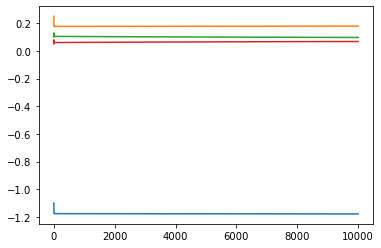

In [41]:
for row in range(len(theta_arr)):
    plt.plot(t, theta_arr[row,:])

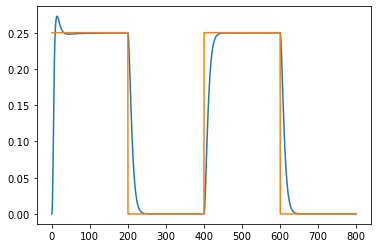

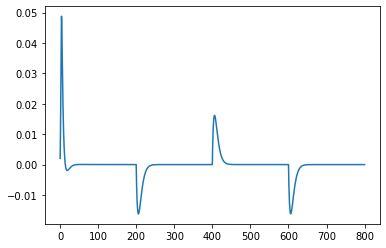

In [42]:
et = 4000
plt.plot(t[0:et], y_measure[0:et])
plt.plot(t[0:et], uc_val[0:et])
plt.show()
plt.plot(t[0:et], u_val[0:et])
plt.show()